<a href="https://www.kaggle.com/code/sinjeongyeol/spaceshiptitanic-binaryclassification-2?scriptVersionId=99760846" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# this notebook is improved before 
https://www.kaggle.com/code/sinjeongyeol/spaceshiptitanic-binaryclassification-1/notebook
notebook

## plus skill
### Target encoding with smoothing
### Add feature
### optimize hyperparameter

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [3]:
feats_cat = []
feats_num = []
for col in train.columns:
    if col in ['PassengerId', 'Transported']:
        continue
    if train[col].dtype == 'object':
        feats_cat += [col]
    else:
        feats_num += [col]
        
feats_cat, feats_num

(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'],
 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [4]:
train_len = len(train)
dataset = pd.concat([train, test], axis=0).reset_index(drop=True)

In [5]:
dataset.shape, train.shape, test.shape

((12970, 14), (8693, 14), (4277, 13))

### PassengerId
### Add group_cnt, group_num

In [6]:
train['PassengerId']

0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object

In [7]:
dataset['group_id'] = 0
dataset['group_num'] = 0
for i in range(len(dataset)):
    group_id, id_at_group = map(int, dataset.iloc[i]['PassengerId'].split('_'))
    dataset.loc[i, 'group_id'] = group_id
    dataset.loc[i, 'group_num'] = id_at_group

In [8]:
dataset = pd.merge(dataset, dataset[['group_id', 'PassengerId']].groupby('group_id').count().reset_index().rename(columns={'PassengerId': 'group_cnt'}), how='left', on='group_id')
dataset = dataset.drop('group_id', axis=1)
dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_cnt
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,1


In [9]:
feats_num += ['group_num', 'group_cnt']

<AxesSubplot:>

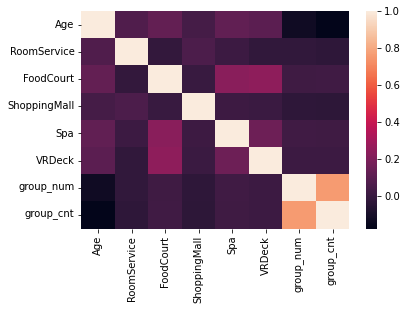

In [10]:
import seaborn as sns

corr = dataset[feats_num].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

<AxesSubplot:xlabel='group_cnt', ylabel='count'>

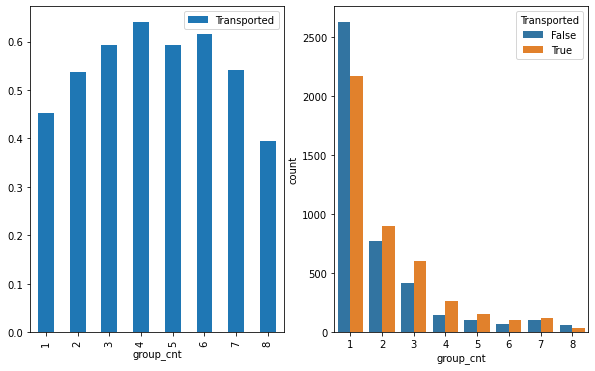

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
dataset[dataset['Transported'].notnull()][['group_cnt', 'Transported']].groupby('group_cnt').mean().plot.bar(ax=ax[0])
sns.countplot(x='group_cnt', data=dataset[dataset['Transported'].notnull()], hue='Transported', ax=ax[1])

<AxesSubplot:xlabel='group_num', ylabel='count'>

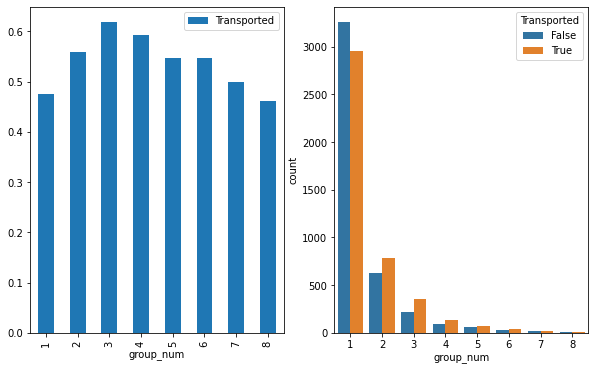

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
dataset[dataset['Transported'].notnull()][['group_num', 'Transported']].groupby('group_num').mean().plot.bar(ax=ax[0])
sns.countplot(x='group_num', data=dataset[dataset['Transported'].notnull()], hue='Transported', ax=ax[1])

#### I'll add this features and decide whether to add it or not after see feature importance 

In [13]:
feats_num, feats_cat

(['Age',
  'RoomService',
  'FoodCourt',
  'ShoppingMall',
  'Spa',
  'VRDeck',
  'group_num',
  'group_cnt'],
 ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'])

## Cabin
### The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

In [14]:
dataset['Cabin']

0           B/0/P
1           F/0/S
2           A/0/S
3           A/0/S
4           F/1/S
           ...   
12965    G/1496/S
12966         NaN
12967     D/296/P
12968     D/297/P
12969    G/1498/S
Name: Cabin, Length: 12970, dtype: object

In [15]:
dataset['Cabin'].isnull().mean()

0.023053199691595992

In [16]:
dataset['Cabin_deck'] = np.NaN
dataset['Cabin_num'] = np.NaN
dataset['Cabin_side'] = np.NaN
for i in range(len(dataset)):
    if pd.isna(dataset.iloc[i]['Cabin']):
        continue
    deck, num, side = dataset.iloc[i]['Cabin'].split('/')
    dataset.loc[i, 'Cabin_deck'] = deck
    dataset.loc[i, 'Cabin_num'] = int(num)
    dataset.loc[i, 'Cabin_side'] = side

In [17]:
dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_cnt,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,1,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,2,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,2,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,1,F,1.0,S


In [18]:
dataset['Cabin_deck'].value_counts()

F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: Cabin_deck, dtype: int64

<AxesSubplot:xlabel='Cabin_deck', ylabel='count'>

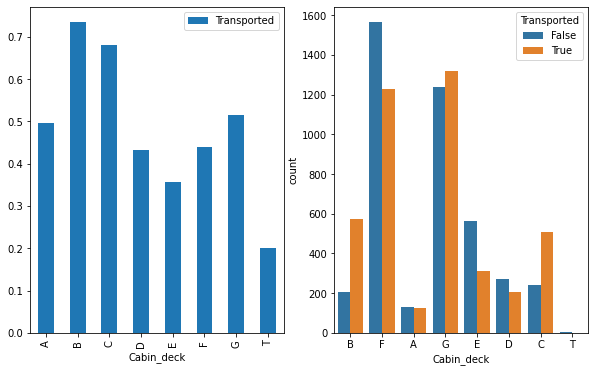

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
dataset[dataset['Transported'].notnull()][['Cabin_deck', 'Transported']].groupby('Cabin_deck').mean().plot.bar(ax=ax[0])
sns.countplot(x='Cabin_deck', data=dataset[dataset['Transported'].notnull()], hue='Transported', ax=ax[1])

### There is very little 'T' value of 'Cabin_deck' feature
### I'll decide whether to add this or not later

In [20]:
dataset['Cabin_num'].value_counts()

82.0      34
4.0       28
56.0      28
95.0      27
31.0      27
          ..
1848.0     1
1847.0     1
1846.0     1
1844.0     1
1890.0     1
Name: Cabin_num, Length: 1894, dtype: int64

<AxesSubplot:xlabel='Cabin_num', ylabel='Density'>

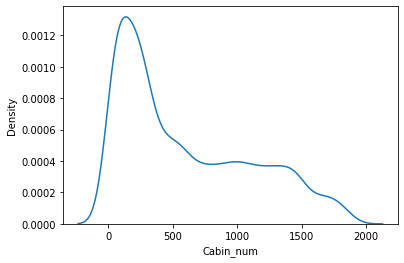

In [21]:
sns.kdeplot(x='Cabin_num', data=dataset)

<AxesSubplot:xlabel='Cabin_num', ylabel='Density'>

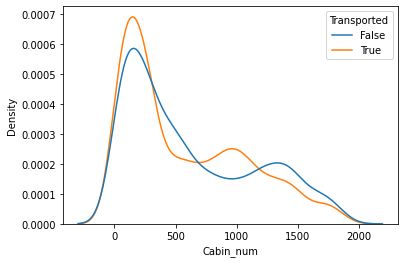

In [22]:
sns.kdeplot(x='Cabin_num', data=dataset[dataset['Transported'].notnull()], hue='Transported')

In [23]:
dataset['Cabin_side'].value_counts()

S    6381
P    6290
Name: Cabin_side, dtype: int64

<AxesSubplot:xlabel='Cabin_side', ylabel='count'>

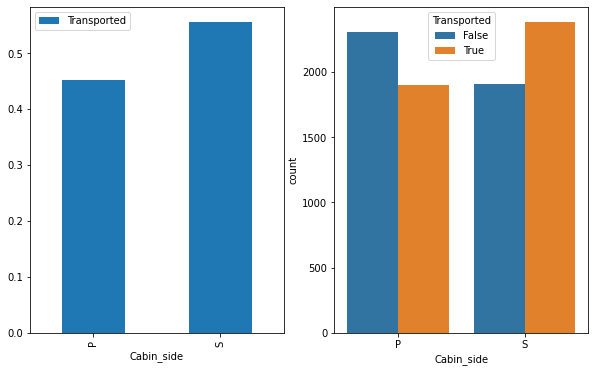

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
dataset[dataset['Transported'].notnull()][['Cabin_side', 'Transported']].groupby('Cabin_side').mean().plot.bar(ax=ax[0])
sns.countplot(x='Cabin_side', data=dataset[dataset['Transported'].notnull()], hue='Transported', ax=ax[1])

In [25]:
dataset = dataset.drop('Cabin', axis=1)

In [26]:
dataset.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_cnt,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,1,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,2,A,0.0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,2,A,0.0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,1,F,1.0,S


In [27]:
if 'Cabin' in feats_cat:
    feats_cat.remove('Cabin')
feats_cat.append('Cabin_deck')
feats_cat.append('Cabin_side')
feats_num.append('Cabin_num')
feats_cat, feats_num

(['HomePlanet',
  'CryoSleep',
  'Destination',
  'VIP',
  'Name',
  'Cabin_deck',
  'Cabin_side'],
 ['Age',
  'RoomService',
  'FoodCourt',
  'ShoppingMall',
  'Spa',
  'VRDeck',
  'group_num',
  'group_cnt',
  'Cabin_num'])

## Target encoding with smoothing